In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_2_vs_4_binary_predictor"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = [ 2, 4 ]

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11776, 28, 28, 1)
n train samples = 11776
n test samples = 1984


In [3]:
#Make binary labels

digit_train = np.argmax(y_train, axis=-1)
digit_test = np.argmax(y_test, axis=-1)

y_train = np.zeros((digit_train.shape[0], 1))
y_train[digit_train == included_classes[0], 0] = 0
y_train[digit_train == included_classes[1], 0] = 1

y_test = np.zeros((digit_test.shape[0], 1))
y_test[digit_test == included_classes[0], 0] = 0
y_test[digit_test == included_classes[1], 0] = 1


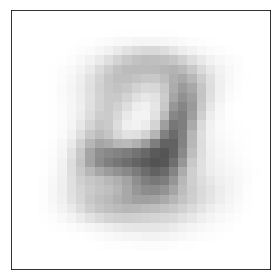

In [4]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [5]:
#Calculate mean training set conservation

entropy = (x_mean * -np.log(x_mean) + (1. - x_mean) * -np.log(1. - x_mean)) / np.log(2.0)
conservation = 1.0 - entropy

x_mean_conservation = np.mean(conservation)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.6241306924499999


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, :, :, 0]), 1e-8, 1. - 1e-8)

x_mean_broadcasted = np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))

kl_divs = (x_train_clipped * np.log(x_train_clipped / x_mean_broadcasted) + (1. - x_train_clipped) * np.log((1. - x_train_clipped) / (1. - x_mean_broadcasted))) / np.log(2.0)

x_mean_kl_divs = np.mean(kl_divs, axis=(1, 2))
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 0.3753392663167618


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/binary-stochastic-neurons-in-tensorflow.html
#See Github https://github.com/spitis/

def bernoulli_sample(x):
    g = tf.get_default_graph()
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]


In [8]:
#Masking and Sampling helper functions

def sample_image_st(x) :
    p = tf.sigmoid(x)

    return bernoulli_sample(p)

#Generator helper functions
def initialize_templates(generator, background_matrices) :

    embedding_backgrounds = []

    for k in range(len(background_matrices)) :
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=1) :

    #Initialize Reshape layer
    reshape_layer = Reshape((n_rows, n_cols, 1))
    
    #Initialize background matrix
    background_dense = Embedding(n_classes, n_rows * n_cols, embeddings_initializer='zeros', name='background_dense')

    #Initialize Templating and Masking Lambda layer
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize Sigmoid layer
    image_layer = Lambda(lambda x: K.sigmoid(x), name='image')
    
    #Initialize Sampling layers
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_image_st, name='image_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, n_rows, n_cols, 1)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        background = reshape_layer(background_dense(class_input))
        
        #Add Template and Multiply Mask
        image_logits = background_layer([raw_logits, background])
        
        #Compute Image (Sigmoids from logits)
        image = image_layer(image_logits)
        
        #Tile each image to sample from and create sample axis
        image_logits_upsampled = upsampling_layer(image_logits)
        sampled_image = sampling_layer(image_logits_upsampled)
        sampled_image = permute_layer(sampled_image)
        
        return image_logits, image, sampled_image
    
    return _sampler_func


In [9]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def get_rand_lum(lum, x, min_lum=0.1, max_lum=0.5) :
    
    rand_lum = K.random_uniform(shape=K.shape(lum), minval=min_lum, maxval=max_lum)
    
    return K.switch(K.learning_phase(), rand_lum, lum)

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0, feature_min_lum=0.1, feature_max_lum=0.5) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    rand_lum = Lambda(lambda x: get_rand_lum(x[0], x[1], min_lum=feature_min_lum, max_lum=feature_max_lum))
    lum_concat = Lambda(lambda x: K.concatenate([x[0], K.tile(K.expand_dims(K.expand_dims(x[1], axis=1), axis=1), (1, K.shape(x[0])[1], K.shape(x[0])[2], 1))], axis=-1))
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='softplus', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    image_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_image_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] / K.maximum(x[0], K.epsilon()), name='scrambler_logit_scale')
    
    def _scrambler_func(image_input, lum_input) :
        
        rand_lum_out = rand_lum([lum_input, image_input])
        conv_0_out = conv_0(lum_concat([image_input, rand_lum_out]))

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        #Scale logits by importance scores
        scaled_logits = scale_logits([final_conv_out, image_to_logits(image_input)])
        
        return scaled_logits, final_conv_out, rand_lum_out

    return _scrambler_func


In [10]:
#Keras loss functions

def get_sigmoid_kl_divergence() :

    def _sigmoid_kl_divergence(y_true, y_pred) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        
        mean_kl = K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
        
        return mean_kl
    
    return _sigmoid_kl_divergence

def get_margin_lum_ame() :
    
    def _margin_lum_ame(importance_scores, max_lum) :
        
        p_ons = 2. * K.sigmoid(importance_scores[..., 0]) - 1.
        
        mean_p_on = K.mean(p_ons, axis=(1, 2))

        margin_p_on = K.switch(mean_p_on > max_lum[:, 0], mean_p_on - max_lum[:, 0], K.zeros_like(mean_p_on))
    
        return margin_p_on
    
    return _margin_lum_ame

def get_target_lum_sme() :
    
    def _target_lum_sme(importance_scores, target_lum) :
        
        p_ons = 2. * K.sigmoid(importance_scores[..., 0]) - 1.
        
        mean_p_on = K.mean(p_ons, axis=(1, 2))
        
        return (mean_p_on - target_lum[:, 0])**2
    
    return _target_lum_sme

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [11]:
#Initialize Encoder and Decoder networks
batch_size = 32
n_rows = 28
n_cols = 28
n_samples = 32

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0
resnet_feature_min_lum = 0.025
resnet_feature_max_lum = 0.95

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate,
    feature_min_lum=resnet_feature_min_lum,
    feature_max_lum=resnet_feature_max_lum
)

#Load sampler
sampler = build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=n_samples)


In [12]:
#Load Predictor
predictor_path = 'saved_models/mnist_binarized_cnn_digit_2_vs_4.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [13]:
#Create inverted labels

y_train_inv = 1. - y_train
y_test_inv = 1. - y_test


In [14]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(n_rows, n_cols, 1), name='scrambler_input')
scrambler_lum = Input(shape=(1,), name='scrambler_lum')

scrambled_logits, importance_scores, _ = scrambler(scrambler_input, scrambler_lum)

image_logits, image, sampled_image = sampler(scrambler_class, scrambled_logits)

scrambler_model = Model([scrambler_input, scrambler_class, scrambler_lum], [image_logits, image, sampled_image, importance_scores])

#Initialize Templates and Masks
initialize_templates(scrambler_model, [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [15]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(n_rows, n_cols, 1), name='ae_scrambler_input')
ae_scrambler_lum = Input(shape=(1,), name='ae_scrambler_lum')
ae_label_input = Input(shape=(1,), name='ae_label_input')

scrambled_logits, importance_scores, target_lum = scrambler(ae_scrambler_input, ae_scrambler_lum)

#Run encoder and decoder
_, scrambled_image, scrambled_sample = sampler(ae_scrambler_class, scrambled_logits)

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, n_rows, n_cols, 1)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled_deflated = ae_label_input#predictor([ae_scrambler_input])

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = predictor([scrambled_sample_deflated])

#Define layer to inflate sample axis
inflate_non_scrambled_prediction = Lambda(lambda x: K.tile(x, (1, n_samples)), name='inflate_non_scrambled_prediction')
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_non_scrambled = inflate_non_scrambled_prediction(y_pred_non_scrambled_deflated)
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#NLL cost
nll_loss_func = get_sigmoid_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_lum_sme()

#Entropy cost
entropy_loss_func = get_target_lum_sme()
#entropy_loss_func = get_margin_lum_ame()

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1]), name='nll')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([importance_scores, target_lum])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([importance_scores, target_lum])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, ae_scrambler_lum, ae_label_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Templates and Masks
initialize_templates(loss_model, [x_mean_logits])

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=1200.0)
    }
)


In [16]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_lum (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           scrambler_lum[0][0]              
                                                                 scrambler_input[0][0]            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 28, 28, 2)    0           scrambler_input[0][0]            
          

In [17]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ae_scrambler_lum (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           ae_scrambler_lum[0][0]           
                                                                 ae_scrambler_input[0][0]         
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 28, 28, 2)    0           ae_scrambler_input[0][0]         
          

In [18]:
#Training configuration

#Define number of training epochs
n_epochs = 20

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_var_lum_higher_entropy_penalty"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_kl_divergence_var_lum_higher_entropy_penalty


In [19]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

lum_train = np.ones((x_train.shape[0], 1)) * 0.05
lum_test = np.ones((x_test.shape[0], 1)) * 0.05

# train the autoencoder
train_history = loss_model.fit(
    [s_train, x_train, lum_train, y_train_inv],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test, lum_test, y_test_inv],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 11776 samples, validate on 1984 samples
Epoch 1/20
11776/11776 [==============================] - 100s 8ms/step - loss: 2.3777 - nll_loss: 2.3297 - conservation_loss: 0.0480 - entropy_loss: 0.0000e+00 - val_loss: 1.5415 - val_nll_loss: 1.4088 - val_conservation_loss: 0.1326 - val_entropy_loss: 0.0000e+00
Epoch 2/20
11776/11776 [==============================] - 84s 7ms/step - loss: 6.1061 - nll_loss: 2.2572 - conservation_loss: 0.0000e+00 - entropy_loss: 3.8489 - val_loss: 8.3448 - val_nll_loss: 7.7885 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.5563
Epoch 3/20
11776/11776 [==============================] - 84s 7ms/step - loss: 4.0809 - nll_loss: 2.0836 - conservation_loss: 0.0000e+00 - entropy_loss: 1.9973 - val_loss: 7.7340 - val_nll_loss: 7.2802 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.4538
Epoch 4/20
11776/11776 [==============================] - 84s 7ms/step - loss: 3.5481 - nll_loss: 1.9560 - conservation_loss: 0.0000e+00 - entropy_loss: 1.

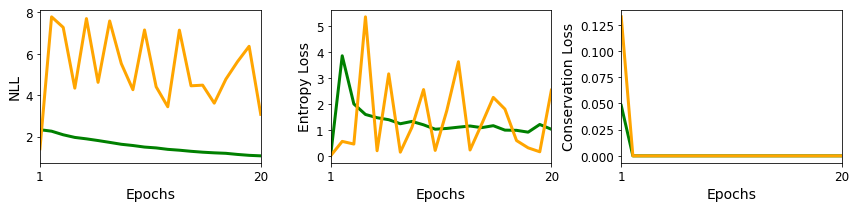

In [20]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [21]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_kl_divergence_var_lum_higher_entropy_penalty.h5 


In [19]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects={
    'bernoulli_sample' : bernoulli_sample,
    'tf' : tf,
    'get_rand_lum' : get_rand_lum
})

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_kl_divergence_var_lum_higher_entropy_penalty.h5 


Test image 0:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.02, 0.29, 0.0, 0.02]


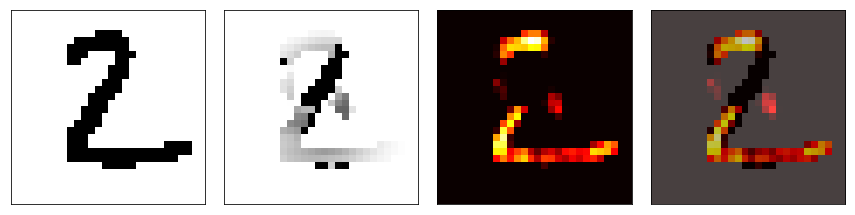

Test image 1:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.03, 0.86, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02]


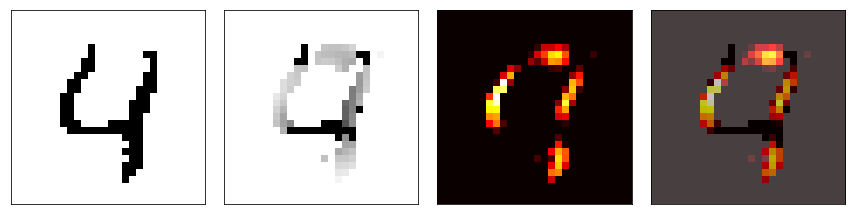

Test image 2:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.02, 0.08, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.02]


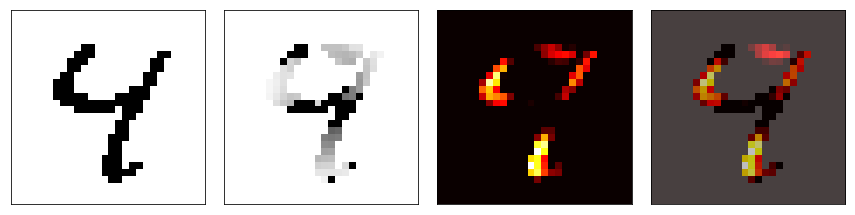

Test image 3:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.0, 0.03, 0.0, 0.02, 0.0, 0.74, 0.49, 0.17, 0.16]


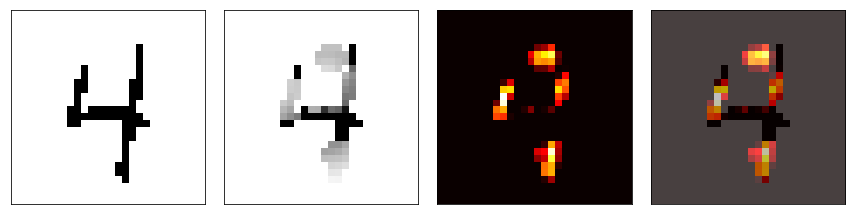

Test image 4:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.12, 0.0, 0.11, 0.05, 0.84, 0.45, 0.05, 0.0, 0.05, 0.03]


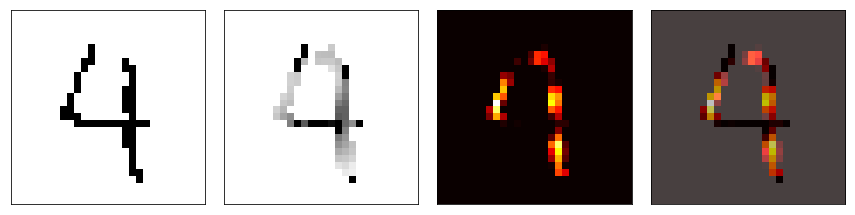

Test image 5:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.0, 0.0, 0.0, 0.01, 0.04, 0.0, 0.0, 0.0, 0.0]


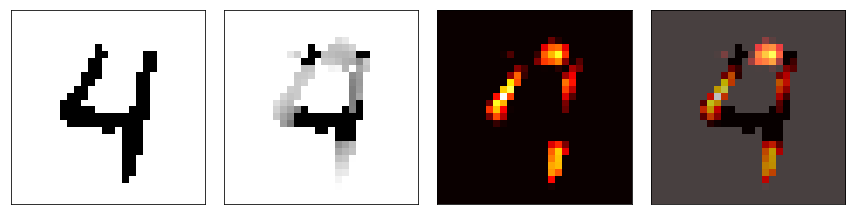

Test image 6:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01]


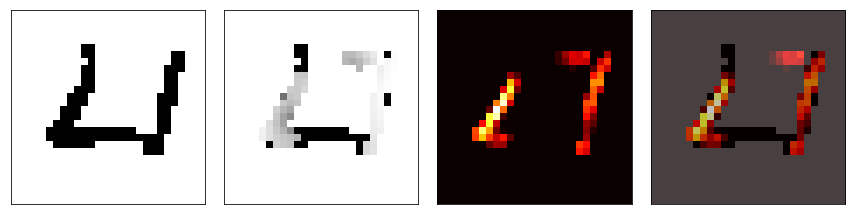

Test image 7:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.0, 0.02, 0.27, 0.0, 0.06, 0.0, 0.43, 0.0, 0.03, 0.34]


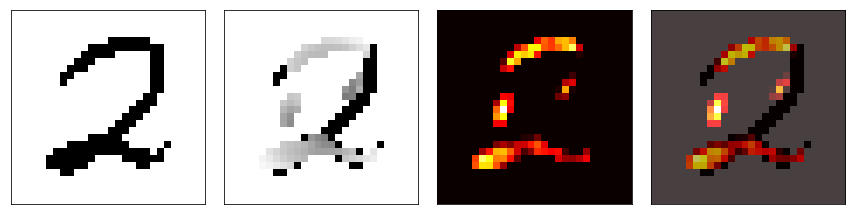

Test image 8:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.43, 0.01, 0.0, 0.04, 0.94, 0.01, 0.13, 0.01, 0.0, 0.01]


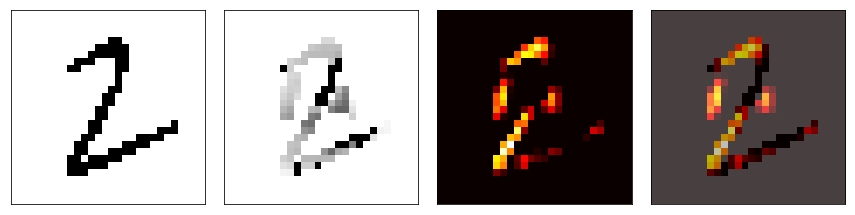

Test image 9:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0]


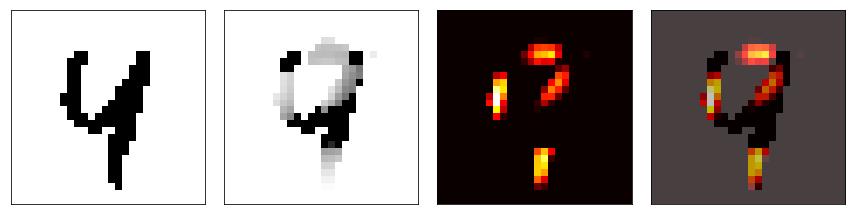

Test image 10:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


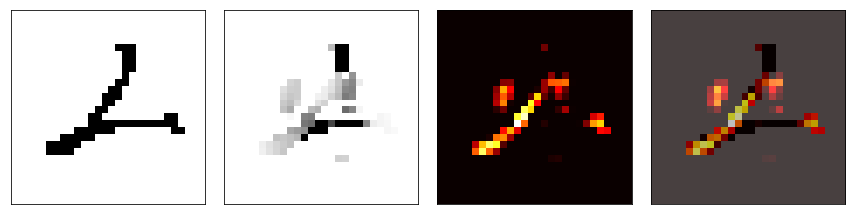

Test image 11:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.04, 0.49, 0.0, 0.03, 0.02, 0.01, 0.4, 0.0, 0.08, 0.02]


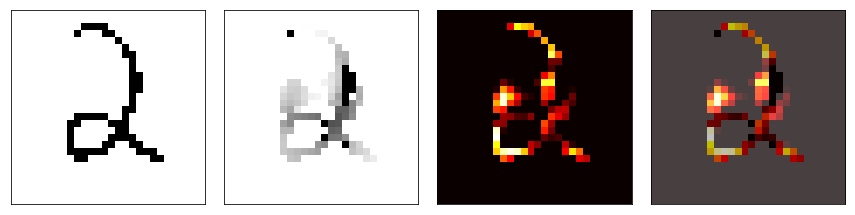

Test image 12:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.66, 0.05, 0.0, 0.02, 0.0, 0.18, 0.1, 0.0, 0.25]


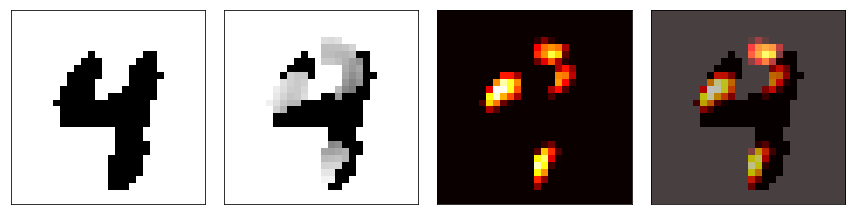

Test image 13:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.19, 0.0, 0.01, 0.49, 0.04, 0.94, 0.0, 0.08, 0.92]


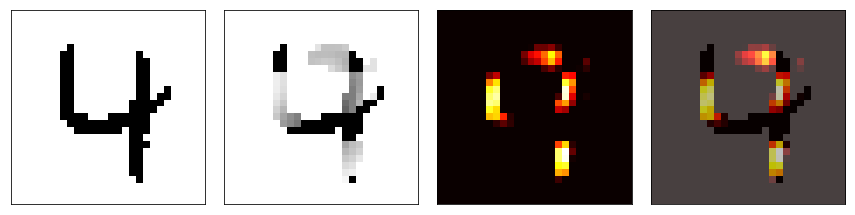

Test image 14:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.0, 0.0, 0.0, 0.05, 0.01, 0.0, 0.0, 0.04, 0.0]


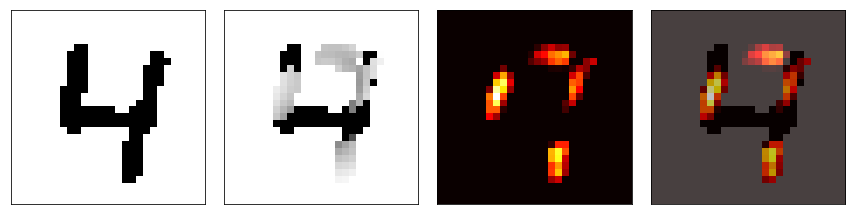

Test image 15:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.06, 0.02, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


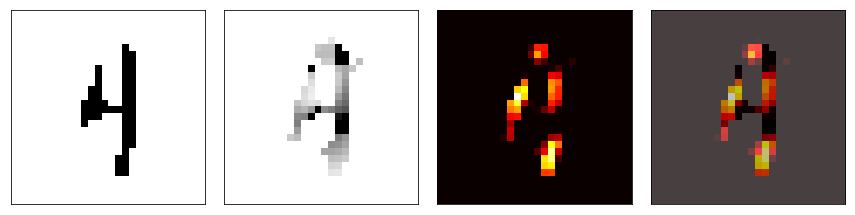

Test image 16:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.81, 0.0, 0.01, 0.0, 0.03, 0.01, 0.06, 0.72, 0.0, 0.03]


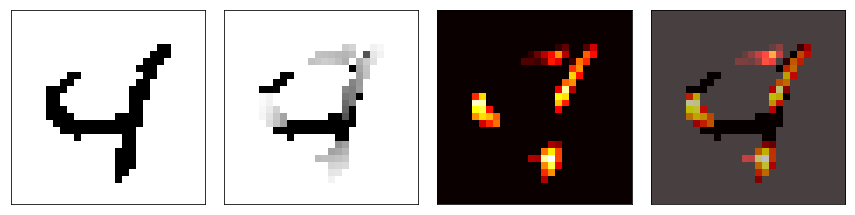

Test image 17:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.0, 0.01, 0.01, 0.0, 0.02, 0.12, 0.03, 0.0, 0.24, 0.2]


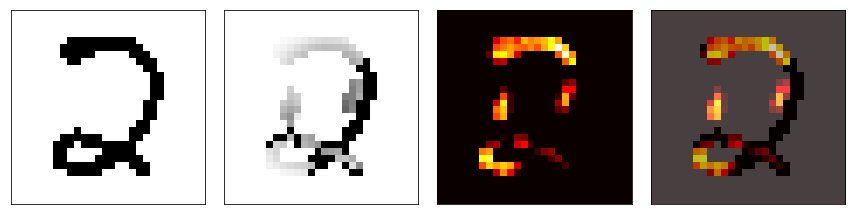

Test image 18:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.99, 0.94, 0.1, 0.76, 0.05, 0.83, 0.76, 0.01, 0.26, 0.06]


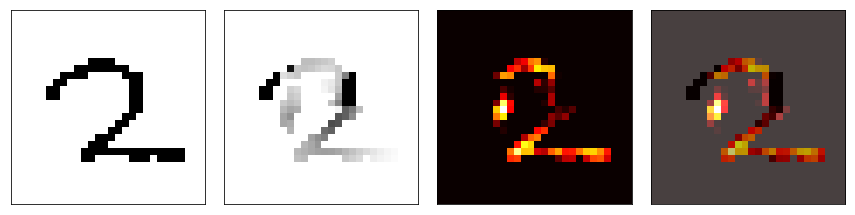

Test image 19:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


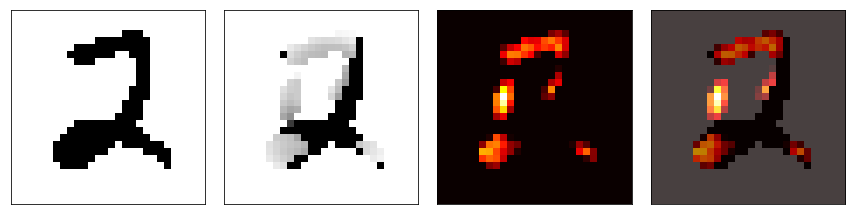

In [20]:
#Visualize a few reconstructed images

from numpy.ma import masked_array

s_test = np.zeros((x_test.shape[0], 1))

lum_test = np.ones((x_test.shape[0], 1)) * 0.05

_, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[x_test[:32], s_test[:32], lum_test[:32]])

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[plot_i], axis=0)], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_test[plot_i]], batch_size=32)[:10, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


Test image 0:
 - Prediction (original) = 0.0
Depth = 0
 - Predictions (scrambled) = [0.42, 0.04, 0.16, 0.01, 0.01, 0.53, 0.18, 0.65, 0.0, 0.36]


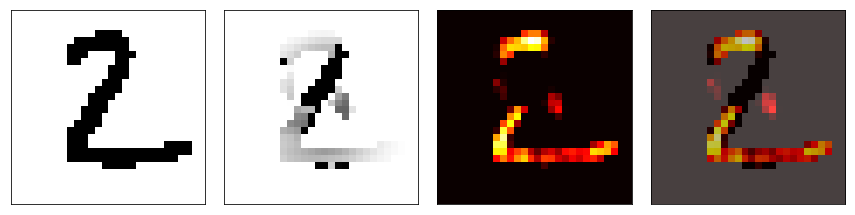

Max Luminescence (logit) = 150.33813
Total Luminescence (logit) = 5921.34
Mean Luminescence (logit) = 7.5527296
Target P(On) = 0.05
Mean P(On) = 0.122667156
Mean KL Div against background (bits) = 0.25154093601204713
Mean Cross-Entropy against example (bits) = 0.22989860040606963
Mean KL Div against against example (bits) = 0.2298944942798241
Depth = 1
 - Predictions (scrambled) = [1.0, 0.51, 0.92, 0.63, 0.22, 0.67, 0.03, 0.98, 0.74, 0.99]


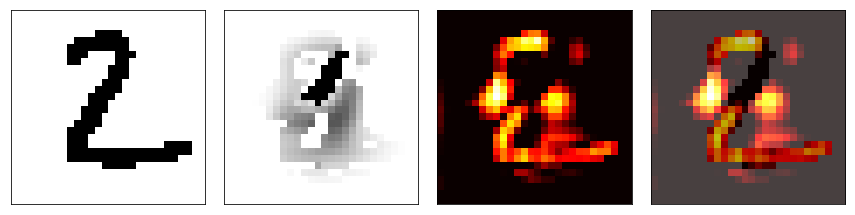

Max Luminescence (logit) = 135.66556
Total Luminescence (logit) = 10330.67
Mean Luminescence (logit) = 13.176875
Target P(On) = 0.25
Mean P(On) = 0.28079513
Mean KL Div against background (bits) = 0.14528510144781245
Mean Cross-Entropy against example (bits) = 0.33298114408490753
Mean KL Div against against example (bits) = 0.3329742146844069
Depth = 2
 - Predictions (scrambled) = [0.57, 0.07, 0.84, 0.06, 0.65, 0.93, 0.99, 0.78, 0.97, 0.98]


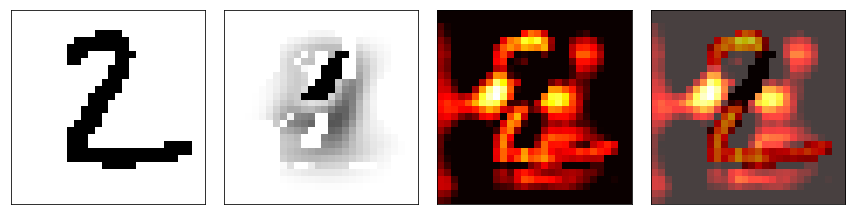

Max Luminescence (logit) = 156.36008
Total Luminescence (logit) = 17992.41
Mean Luminescence (logit) = 22.949503
Target P(On) = 0.45
Mean P(On) = 0.46992669
Mean KL Div against background (bits) = 0.11804648876350685
Mean Cross-Entropy against example (bits) = 0.3615664670661227
Mean KL Div against against example (bits) = 0.36155712735355744
Depth = 3
 - Predictions (scrambled) = [0.51, 0.25, 1.0, 0.11, 0.65, 1.0, 1.0, 1.0, 0.97, 1.0]


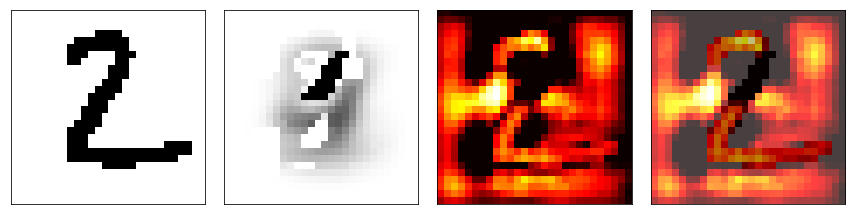

Max Luminescence (logit) = 164.22604
Total Luminescence (logit) = 34124.582
Mean Luminescence (logit) = 43.526253
Target P(On) = 0.75
Mean P(On) = 0.7413886
Mean KL Div against background (bits) = 0.11789445287992367
Mean Cross-Entropy against example (bits) = 0.36068599500429427
Mean KL Div against against example (bits) = 0.36067412890407047


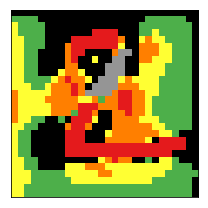

In [21]:
#Predict on test set

save_figs = True

test_ix = 0

n_levels = 4

importance_thresh_qt = 0.0

min_importance_thresh = 10.

lum_levels = [
    0.05,
    0.25,
    0.45,
    0.75
]

print("Test image " + str(test_ix) + ":")
    
y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[test_ix], axis=0)], batch_size=1)[0, 0]

print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])

importance_scores_levels = []
y_test_hat_levels = []

for level_ix in range(n_levels) :
    
    print("Depth = " + str(level_ix))
    
    lum_test = np.ones((batch_size, 1)) * lum_levels[level_ix]
    
    _, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[np.tile(np.expand_dims(x_test[test_ix], axis=0), (batch_size, 1, 1, 1)), np.tile(np.expand_dims(s_test[test_ix], axis=0), (batch_size, 1)), lum_test])

    y_test_hat = predictor.predict(x=[sample_test[0]], batch_size=32)[:, 0].tolist()
    
    y_test_hat_levels.append(y_test_hat)
    
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat[:10]))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[0, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')
    
    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[0, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[0, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".eps")
    
    plt.show()
    
    importance_thresh = np.quantile(np.ravel(importance_scores_test[0, :, :, 0]), q=importance_thresh_qt)
    importance_thresh = max(importance_thresh, min_importance_thresh)
    
    importance_scores_test = importance_scores_test[:1]
    
    max_lum = np.max(importance_scores_test)
    total_lum = np.sum(importance_scores_test)
    mean_lum = np.mean(importance_scores_test)
    mean_p_on = np.mean(2. / (1. + np.exp(-importance_scores_test)) - 1.)
    
    print("Max Luminescence (logit) = " + str(max_lum))
    print("Total Luminescence (logit) = " + str(total_lum))
    print("Mean Luminescence (logit) = " + str(mean_lum))
    print("Target P(On) = " + str(lum_levels[level_ix]))
    print("Mean P(On) = " + str(mean_p_on))
    
    importance_scores_test[importance_scores_test < importance_thresh] = 0.
    if level_ix > 0 :
        importance_scores_levels_above = np.expand_dims(np.sum(np.concatenate(importance_scores_levels[:level_ix], axis=0), axis=0), axis=0)
        importance_scores_test[importance_scores_levels_above > 0] = 0.
    
    importance_scores_levels.append(importance_scores_test)
    
    #Calculate mean kl-divergence against background

    image_test_clipped = np.clip(np.copy(image_test[0, :, :, 0]), 1e-6, 1. - 1e-6)
    x_test_clipped = np.clip(np.copy(x_test[test_ix, :, :, 0]), 1e-6, 1. - 1e-6)

    kl_divs = (image_test_clipped * np.log(image_test_clipped / x_mean) + (1. - image_test_clipped) * np.log((1. - image_test_clipped) / (1. - x_mean))) / np.log(2.0)
    x_mean_kl_div = np.mean(kl_divs)

    print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    
    ces = - x_test[test_ix, :, :, 0] * np.log(image_test_clipped) / np.log(2.) - (1. - x_test[test_ix, :, :, 0]) * np.log(1. - image_test_clipped) / np.log(2.)
    x_mean_ce = np.mean(ces)

    print("Mean Cross-Entropy against example (bits) = " + str(x_mean_ce))
    
    x_kl_divs = (x_test_clipped * np.log(x_test_clipped / image_test_clipped) + (1. - x_test_clipped) * np.log((1. - x_test_clipped) / (1. - image_test_clipped))) / np.log(2.0)
    x_kl_div = np.mean(x_kl_divs)

    print("Mean KL Div against against example (bits) = " + str(x_kl_div))


import numpy.ma as ma

f = plt.figure(figsize=(3, 3))

plt.imshow(1. - x_test[test_ix, :, :, 0], cmap="Greys", vmin=-1.0, vmax=1.0, aspect='equal')

cmap_vals = [
    0,
    4,
    5,
    2
]

for level_ix in range(n_levels) :
    
    importance_scores = importance_scores_levels[level_ix][0, :, :, 0]
    
    importance_scores_masked = ma.array(np.ones(importance_scores.shape), mask = importance_scores <= 0)
    
    plt.imshow(importance_scores_masked * cmap_vals[level_ix], alpha=1.0, cmap='Set1', vmin=0, vmax=8, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.eps")

plt.show()


Test image 1:
 - Prediction (original) = 1.0
Depth = 0
 - Predictions (scrambled) = [0.0, 0.2, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0]


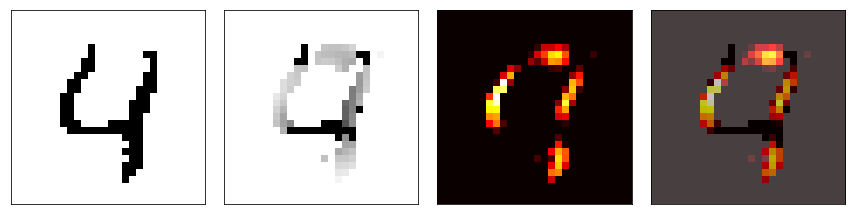

Max Luminescence (logit) = 143.39105
Total Luminescence (logit) = 4408.702
Mean Luminescence (logit) = 5.6233444
Target P(On) = 0.05
Mean P(On) = 0.09676467
Mean KL Div against background (bits) = 0.18825541417712563
Mean Cross-Entropy against example (bits) = 0.11758456683605245
Mean KL Div against against example (bits) = 0.11758115432120354
Depth = 1
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


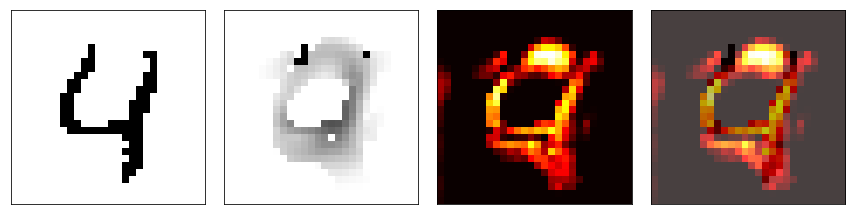

Max Luminescence (logit) = 113.4039
Total Luminescence (logit) = 8715.76
Mean Luminescence (logit) = 11.117041
Target P(On) = 0.25
Mean P(On) = 0.3016975
Mean KL Div against background (bits) = 0.0948717295794099
Mean Cross-Entropy against example (bits) = 0.20601095663199667
Mean KL Div against against example (bits) = 0.2060040232182053
Depth = 2
 - Predictions (scrambled) = [0.05, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0]


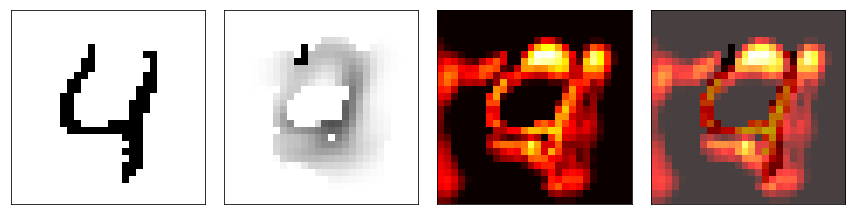

Max Luminescence (logit) = 137.1038
Total Luminescence (logit) = 16535.592
Mean Luminescence (logit) = 21.091316
Target P(On) = 0.45
Mean P(On) = 0.4728034
Mean KL Div against background (bits) = 0.07629675363462812
Mean Cross-Entropy against example (bits) = 0.22604480272506247
Mean KL Div against against example (bits) = 0.22603580424574723
Depth = 3
 - Predictions (scrambled) = [0.07, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0]


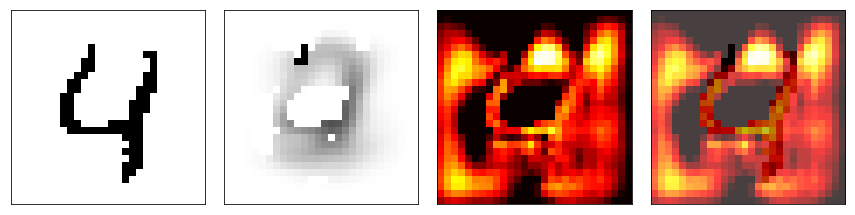

Max Luminescence (logit) = 147.98157
Total Luminescence (logit) = 32014.984
Mean Luminescence (logit) = 40.835438
Target P(On) = 0.75
Mean P(On) = 0.74863714
Mean KL Div against background (bits) = 0.06934466094636449
Mean Cross-Entropy against example (bits) = 0.23460108075594652
Mean KL Div against against example (bits) = 0.23458920699042263


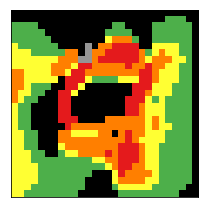

In [22]:
#Predict on test set

save_figs = True

test_ix = 1

n_levels = 4

importance_thresh_qt = 0.0

min_importance_thresh = 10.

lum_levels = [
    0.05,
    0.25,
    0.45,
    0.75
]

print("Test image " + str(test_ix) + ":")
    
y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[test_ix], axis=0)], batch_size=1)[0, 0]

print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])

importance_scores_levels = []
y_test_hat_levels = []

for level_ix in range(n_levels) :
    
    print("Depth = " + str(level_ix))
    
    lum_test = np.ones((batch_size, 1)) * lum_levels[level_ix]
    
    _, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[np.tile(np.expand_dims(x_test[test_ix], axis=0), (batch_size, 1, 1, 1)), np.tile(np.expand_dims(s_test[test_ix], axis=0), (batch_size, 1)), lum_test])

    y_test_hat = predictor.predict(x=[sample_test[0]], batch_size=32)[:, 0].tolist()
    
    y_test_hat_levels.append(y_test_hat)
    
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat[:10]))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[0, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')
    
    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[0, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[0, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".eps")
    
    plt.show()
    
    importance_thresh = np.quantile(np.ravel(importance_scores_test[0, :, :, 0]), q=importance_thresh_qt)
    importance_thresh = max(importance_thresh, min_importance_thresh)
    
    importance_scores_test = importance_scores_test[:1]
    
    max_lum = np.max(importance_scores_test)
    total_lum = np.sum(importance_scores_test)
    mean_lum = np.mean(importance_scores_test)
    mean_p_on = np.mean(2. / (1. + np.exp(-importance_scores_test)) - 1.)
    
    print("Max Luminescence (logit) = " + str(max_lum))
    print("Total Luminescence (logit) = " + str(total_lum))
    print("Mean Luminescence (logit) = " + str(mean_lum))
    print("Target P(On) = " + str(lum_levels[level_ix]))
    print("Mean P(On) = " + str(mean_p_on))
    
    importance_scores_test[importance_scores_test < importance_thresh] = 0.
    if level_ix > 0 :
        importance_scores_levels_above = np.expand_dims(np.sum(np.concatenate(importance_scores_levels[:level_ix], axis=0), axis=0), axis=0)
        importance_scores_test[importance_scores_levels_above > 0] = 0.
    
    importance_scores_levels.append(importance_scores_test)
    
    #Calculate mean kl-divergence against background

    image_test_clipped = np.clip(np.copy(image_test[0, :, :, 0]), 1e-6, 1. - 1e-6)
    x_test_clipped = np.clip(np.copy(x_test[test_ix, :, :, 0]), 1e-6, 1. - 1e-6)

    kl_divs = (image_test_clipped * np.log(image_test_clipped / x_mean) + (1. - image_test_clipped) * np.log((1. - image_test_clipped) / (1. - x_mean))) / np.log(2.0)
    x_mean_kl_div = np.mean(kl_divs)

    print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    
    ces = - x_test[test_ix, :, :, 0] * np.log(image_test_clipped) / np.log(2.) - (1. - x_test[test_ix, :, :, 0]) * np.log(1. - image_test_clipped) / np.log(2.)
    x_mean_ce = np.mean(ces)

    print("Mean Cross-Entropy against example (bits) = " + str(x_mean_ce))
    
    x_kl_divs = (x_test_clipped * np.log(x_test_clipped / image_test_clipped) + (1. - x_test_clipped) * np.log((1. - x_test_clipped) / (1. - image_test_clipped))) / np.log(2.0)
    x_kl_div = np.mean(x_kl_divs)

    print("Mean KL Div against against example (bits) = " + str(x_kl_div))


import numpy.ma as ma

f = plt.figure(figsize=(3, 3))

plt.imshow(1. - x_test[test_ix, :, :, 0], cmap="Greys", vmin=-1.0, vmax=1.0, aspect='equal')

cmap_vals = [
    0,
    4,
    5,
    2
]

for level_ix in range(n_levels) :
    
    importance_scores = importance_scores_levels[level_ix][0, :, :, 0]
    
    importance_scores_masked = ma.array(np.ones(importance_scores.shape), mask = importance_scores <= 0)
    
    plt.imshow(importance_scores_masked * cmap_vals[level_ix], alpha=1.0, cmap='Set1', vmin=0, vmax=8, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.eps")

plt.show()
